In [66]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [67]:
path = "C:\\Users\\ankita\\jupyter_notebooks\\RA\\txg01012020to06062020.csv"
data_TXG = pd.read_csv(path)
#data_TXG = data_TXG.sort_values(by = ['Date'])

In [120]:
def buy_to_hold(buy):
    
    hold = np.zeros(len(buy))
    signal = 0
    
    for i in range(len(buy)):
        if buy[i] == 1:
            signal = 1
        elif buy[i] == -1:
            signal = 0
        
        hold[i] = signal
    
    return(hold)

#def returns(hold , price , daily_scale = 252):
    #returns a vector of annualized returns
    
    
    #returns_set = list()

    
    #for t in range(0, len(hold)):
        
        #if (hold[t] == 1 and t == 0) or (hold[t-1] == 0 and hold[t] == 1):
            #buy = price[t]
            #time_point_buy = t
            
        #elif t > 0 and hold[t-1] == 1 and hold[t] == 0:
            #sell = price[t]
            #time_point_sell = t
            
            #rate_of_return = (sell - buy)/buy
            #days_held = time_point_sell - time_point_buy
            #r = (1 + rate_of_return)**(daily_scale/days_held) - 1 
            
            #returns_set.append(r)
    
    #returns_set = np.array(returns_set)
    #print(returns_set)
    #return(returns_set)

#def annualized_volatility(val , daily_scale = 252):
    
    #perc_daily_change = (np.diff(val)/val[:-1])*100
    #daily_volatality = np.std(perc_daily_change)
    #annual_volatality = daily_volatality*(daily_scale**(1/2))
    
    #return(annual_volatality)

def annualized_volatility(val , daily_scale = 252):
    
    perc_daily_change = (np.diff(val)/val[:-1])
    perc_daily_change = perc_daily_change[np.where(perc_daily_change!=0)[0]]
    daily_volatality = np.std(perc_daily_change)
    annual_volatality = daily_volatality*(daily_scale**(1/2))
    
    return(annual_volatality)

#def annualized_return(val , daily_scale = 252):
    
    #n_holding_periods = len(val)
    #val = 1 + val
    #print("1+returns",val)
    #a_return = (np.prod(val))**(1/n_holding_periods) - 1
    #print("prod",np.prod(val))
    #print("a_return",a_return)
    
    #return(a_return*100)


def annualized_return(val, daily_scale = 252):
    
    diff = np.diff(val)
    
    buy_time_index = np.where(diff != 0)[0][0]
    sell_time_index = np.where(diff != 0)[0][-1] + 1
    interval = sell_time_index - buy_time_index + 1
    
    buy = val[buy_time_index]
    sell = val[sell_time_index]
    
    return_rate = sell/buy
    
    
    #print(interval)
    #r = (return_rate + 1)**(252/interval) - 1
    r = (return_rate)**(252/interval) - 1
    
    return(r*100)

#def annualized_return(val, daily_scale = 252):
    
    #diff = np.diff(val)

    #buy_time_indices = np.where([True if ((i-1)>0 and diff[i-1] == 0 and diff[i] != 0) else False for i in range(0,len(diff))])[0]
    #sell_time_index = np.where([True if (i-1 >=0 and diff[i-1] != 0 and diff[i] == 0) else False for i in range(0,len(diff))])[0][-1]
    #sell_time_index = len(val) - 1
    
    #if buy_time_indices.size == 0:
         #buy_time_index = 0
    #else:
        #buy_time_index = buy_time_indices[0]
    
    #buy = val[buy_time_index]
    #sell = val[sell_time_index]
    
    #return_rate = (sell - buy)/buy
    #interval = sell_time_index - buy_time_index + 1
    #r = (return_rate + 1)**(252/interval) - 1
    
    #return(r)


def MaximumDrawDown(val):
    
    high = val[0]
    low = val[0]
    MDD_max = 0
    
    for i in range(len(val)):
        
        if val[i] > high:
            high = val[i]
            high_changed = i
            low = high
        
        if val[i] < low:
            low = val[i]
        
        
        if high != low:
            MDD = (high - low)/high
            
            if MDD > MDD_max:
                MDD_max = MDD
    
    return(MDD_max*100)


def trade_MA(price, ma_fast = 5, ma_slow = 10):
    
    SMA_5 = price.rolling(window = ma_fast).mean()
    SMA_10 = price.rolling(window = ma_slow).mean()
    
    difference = SMA_5.diff()
    difference_rolling_sum = difference.rolling(window = 7).sum()
    
    #setting up the cross indicator 
    cross_indicator = [ 1 if ((SMA_5[i] <= SMA_10[i] and SMA_5[i+1] >= SMA_10[i+1]) or (SMA_5[i] >= SMA_10[i] and SMA_5[i+1] <= SMA_10[i+1])) else 0 for i in range(len(SMA_5) -1)]
    
    #checking if a cross might have occured in the past
    diff_MA = SMA_5 - SMA_10
    diff_MA = diff_MA[~np.isnan(diff_MA)]
    
    if all(i > 0 for i in diff_MA[:5]) == True or all(i < 0 for i in diff_MA[:5]) == True:
        cross_past = 1
    else:
        cross_past = 0
        
    #setting up the trend indicator
    #1 indicates an upward trend, -1 indicates a downward trend else 0
    trend_indicator = [1 if i > 0 else -1 if i < 0 else 0 for i in difference_rolling_sum]
    
    cross = 0 #indicating if a cross occurred
    trend_changed = 0 #indicating if trend changed direction
    trend_direction = 0 #indicating the direction of trend
    
    buy_sell = np.zeros(len(price)) 
    
    for i in range(len(cross_indicator)):
        
        trend_direction = trend_indicator[i]
        
        #if cross_indicator[i] == 1:
            #cross = 1
        if (i-2) >= 0 and (cross_indicator[i-2] == 1):
            cross = 1
        else:
            cross = 0
            
            
        if (cross == 1 or cross_past == 1) and trend_direction == 1:
            cross_past = 0
            buy_sell[i] = 1
        elif (cross == 1 or cross_past == 1) and trend_direction == -1:
            cross_past = 0
            buy_sell[i] = -1
        
    hold = buy_to_hold(buy_sell)
    
    return(hold)

def trade_buy_hold(time_point_buy, time_point_sell, price):
    
    #time_point_buy - list of all time points when the stock is bought
    #time_point_sell - list of all time points when the stock is sold
    #price - list of prices at all time points
    
    hold = np.zeros(len(price))
    
    for i,j in zip(time_point_buy,time_point_sell):
        hold[i-1:j-1] = 1
    
    return(hold)

def price2invest(hold,price,cash):
    #returns the portfolio for a strategy
    
    portfolio = []
    start = -1 #to indicate the time point when trading began
    
    if hold[0] == 1:
        start = 0
        shares = cash/price[0]
        hold_price = shares*price[0]
    else:
        hold_price = cash
        shares = 0
    
    portfolio.append(hold_price)
    
    for i in range(1,len(hold)):
        
        if hold[i-1] == 0 and hold[i] == 1:
            if start == -1:
                start = i
            shares = cash/price[i]
        
        if hold[i] == 1:
            hold_price = shares*price[i]
            #cash = hold_price
        if hold[i-1] == 1 and hold[i] == 0:
            cash = shares*price[i]
            hold_price = cash
            #hold_price = price[i]
        
        portfolio.append(hold_price)
    
    
    return(portfolio)

In [121]:
price = data_TXG['TXG.Adjusted']
hold_MA = trade_MA(price)
portfolio_MA = np.array(price2invest(hold_MA,price,price[0]))

time_point_buy = [1]
time_point_sell = [len(price)]
hold_buyhold = trade_buy_hold(time_point_buy , time_point_sell, price)
portfolio_buyhold = np.array(price2invest(hold_buyhold,price,price[0]))

#annualized volatility
annualized_volatility_MA = annualized_volatility(portfolio_MA)
annualized_volatility_buyhold = annualized_volatility(portfolio_buyhold)

#annualized return
annualized_return_MA = annualized_return(portfolio_MA)
annualized_return_buyhold = annualized_return(portfolio_buyhold)

#Maximum DrawDown
MDD_MA = MaximumDrawDown(portfolio_MA)
MDD_buyhold = MaximumDrawDown(portfolio_buyhold)




print("Trading Strategy MA")
print("annualized volatility",annualized_volatility_MA)
print("annualized return",annualized_return_MA)
print("maximum drawdown",MDD_MA)
print()
print("Trading Strategy buy hold")
print("annualized volatility",annualized_volatility_buyhold)
print("annualized return",annualized_return_buyhold)
print("maximum drawdown",MDD_buyhold)

Trading Strategy MA
annualized volatility 0.54610608183703
annualized return 140.56747003976108
maximum drawdown 19.76290792898485

Trading Strategy buy hold
annualized volatility 0.6100904447572698
annualized return 33.309177785985234
maximum drawdown 51.63196534518949


In [107]:
ma_fast = 5
ma_slow = 10
SMA_5 = price.rolling(window = ma_fast).mean()
SMA_10 = price.rolling(window = ma_slow).mean()
MA = pd.DataFrame({'MA_5':SMA_5, 'MA_10':SMA_10,'holdingvalue':portfolio_MA,'Date':data_TXG['Date'],'TXG.close':data_TXG['TXG.Close']})

fig = go.Figure()
fig.add_trace(go.Scatter(x = MA['Date'], y = MA['MA_5'], mode = 'lines', name = 'MA_5'))
fig.add_trace(go.Scatter(x = MA['Date'], y = MA['MA_10'], mode = 'lines', name = 'MA_10'))
fig.add_trace(go.Scatter(x = MA['Date'], y = MA['holdingvalue'], mode = 'lines', name = 'holdvalue'))
fig.add_trace(go.Scatter(x = MA['Date'], y = MA['TXG.close'], mode = 'lines', name = 'closingprice', line = dict(color = "orange")))
fig.update_layout(autosize = False, width = 600, height = 500, yaxis_title = "Price",
                 title={'text': "TXG",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

[Text(0, 0, '1/2/2020'),
 Text(0, 0, '1/9/2020'),
 Text(0, 0, '1/16/2020'),
 Text(0, 0, '1/24/2020'),
 Text(0, 0, '1/31/2020'),
 Text(0, 0, '2/7/2020'),
 Text(0, 0, '2/14/2020'),
 Text(0, 0, '2/24/2020'),
 Text(0, 0, '3/2/2020'),
 Text(0, 0, '3/9/2020'),
 Text(0, 0, '3/16/2020'),
 Text(0, 0, '3/23/2020'),
 Text(0, 0, '3/30/2020'),
 Text(0, 0, '4/6/2020'),
 Text(0, 0, '4/14/2020'),
 Text(0, 0, '4/21/2020'),
 Text(0, 0, '4/28/2020'),
 Text(0, 0, '5/5/2020'),
 Text(0, 0, '5/12/2020'),
 Text(0, 0, '5/19/2020'),
 Text(0, 0, '5/27/2020'),
 Text(0, 0, '6/3/2020')]

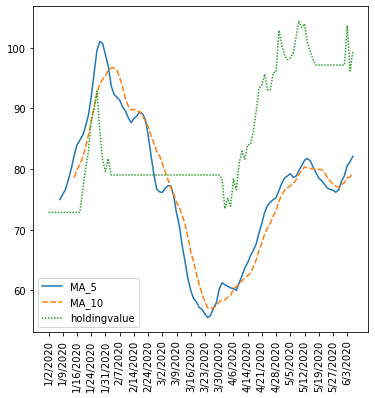

In [389]:
MA = pd.DataFrame({'MA_5':SMA_5, 'MA_10':SMA_10,'holdingvalue':portfolio_MA})
index = MA.index

plt.figure(figsize = (6,6))
ax = sns.lineplot(data = MA)
ax.set_xticks(index[::5])
ax.set_xticklabels(data_TXG['Date'][::5], rotation = 90)